51
[1, 4, 8, 12, 16, 20, 24, 28, 32, 36, 40, 44, 48, 52, 56, 60, 64, 68, 72, 76, 80, 84, 88, 92, 96, 100, 104, 108, 112, 116, 120, 124, 128, 132, 136, 140, 144, 148, 152, 156, 160, 164, 168, 172, 176, 180, 184, 188, 200, 220, 240]
[0, 2, 3, 5, 6, 7, 9, 10, 11, 13, 14, 15, 17, 18, 19, 21, 22, 23, 25, 26, 27, 29, 30, 31, 33, 34, 35, 37, 38, 39, 41, 42, 43, 45, 46, 47, 49, 50, 51, 53, 54, 55, 57, 58, 59, 61, 62, 63, 65, 66, 67, 69, 70, 71, 73, 74, 75, 77, 78, 79, 81, 82, 83, 85, 86, 87, 89, 90, 91, 93, 94, 95, 97, 98, 99, 101, 102, 103, 105, 106, 107, 109, 110, 111, 113, 114, 115, 117, 118, 119, 121, 122, 123, 125, 126, 127, 129, 130, 131, 133, 134, 135, 137, 138, 139, 141, 142, 143, 145, 146, 147, 149, 150, 151, 153, 154, 155, 157, 158, 159, 161, 162, 163, 165, 166, 167, 169, 170, 171, 173, 174, 175, 177, 178, 179, 181, 182, 183, 185, 186, 187, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 

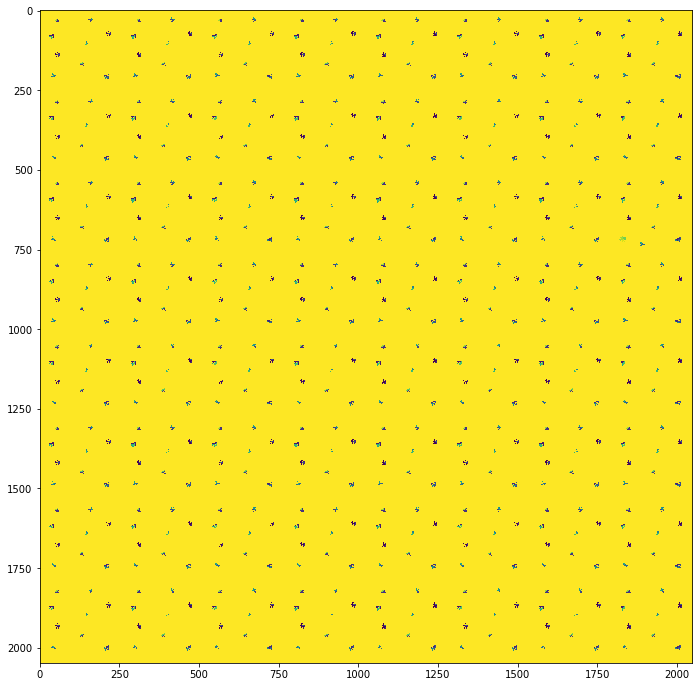

In [1]:
%matplotlib inline
import math
import numpy as np
import matplotlib.pyplot as plt
# import imageio as imio
import PIL.Image as pi
import opensimplex as sim

used = [200, 220, 240, 1, 4, 8, 12, 16, 20, 24, 28, 32, 36, 40, 44, 48, 52, 56, 60, 64, 68, 72, 76, 80, 84, 88, 92, 96, 100, 104, 108, 112, 116, 120, 124, 128, 132, 136, 140, 144, 148, 152, 156, 160, 164, 168, 172, 176, 180, 184, 188]
print(len(used))
print(sorted(used))
complete = [x for x in range(256)]
print(list(filter(lambda x: x not in used, complete)))


# im = imio.imread('D:\steam\steamapps\common\SpaceEngineers\Content\Data\PlanetDataFiles\EarthLike\\front_mat.png')
im = pi.open('D:\steam\steamapps\common\SpaceEngineers\Content\Data\PlanetDataFiles\Moon\\up_mat.png')
print(im.mode)
data = np.asarray(im)
blue = data[...,2]
print(blue.shape)
fig, ax = plt.subplots(figsize=(12, 12))
ax.imshow(blue[:,:])
hist = np.array([0] * 256)
for b in blue.reshape([-1]):
    hist[b] += 1
hist, counts = np.unique(blue, return_counts=True)
print(hist)
print(counts)
hist = {i:v for i,v in zip(hist, counts)}
print(hist)
print(2048 * 2048 - hist[255])

def count_resource(resource, values):
    accum = 0
    for res in values:
        print(res, hist.get(res, 0))
        accum += hist.get(res, 0)
    print(resource + ':', accum)
    
count_resource('iron', (1, 4, 8, 12, 16, 20))
count_resource('nickel', (24, 28, 32, 36, 40, 44))
count_resource('silicon', (48, 52, 56, 60, 64, 68))
count_resource('cobalt', (72, 76, 80, 84, 88, 92, 156, 160, 164))
count_resource('silver', (96, 100, 104, 108, 112, 116))
count_resource('magnesium', (120, 124, 128))
count_resource('ice', (132, 136, 140, 144, 148, 152))
count_resource('gold', (168, 172, 176, 180, 184, 188))

In [2]:
%matplotlib inline
import math
import os
import numpy as np
import matplotlib.pyplot as plt
import PIL.Image as pi
import opensimplex as sim
def get_sub_noise(height, width, octaves):

    osm = sim.OpenSimplex()
    submaps = np.zeros((len(octaves), height, width), dtype=np.float)
    for oi, o in enumerate(octaves):
        print(o)
        for y in range(height):
            for x in range(width):
                submaps[oi, x, y] += osm.noise2d(x/o, y/o)
    submapdict = {o: submaps[oi] for oi, o in enumerate(octaves)}
    return submapdict    

def generate_offsets(value_count, octave_count, size):
    import random
    random.seed(1234)
    rng = lambda: random.randint(0, size)
    offsets = list()
    for i in range(value_count):
        offset = tuple((rng(), rng()) for _ in range(octave_count))
        offsets.append(offset)

    return offsets

def get_ore_map(height, width, worldmap_dict, add_octaves, sub_octaves, amplitudes, offsets):
    result = np.zeros((height, width), dtype=np.float)
    for oi, o in enumerate(add_octaves):
        ofs = offsets[oi]
        result += worldmap_dict[o][ofs[0]:ofs[0]+height, ofs[1]:ofs[1]+width] * amplitudes[oi]
    for oi, o in enumerate(sub_octaves):
        ofs = offsets[oi]
        result -= worldmap_dict[o][ofs[0]:ofs[0]+height, ofs[1]:ofs[1]+width] * amplitudes[oi]
        #result -= worldmap_dict[o][:height,:width] * amplitudes[oi] * 0.5
    return np.interp(result, (result.min(), result.max()), (0, 1))

def get_ore_map_2(height, width, worldmap_dict, add_octaves, sub_noise, amplitudes, offsets, filament_weight):
    result = np.zeros((height, width), dtype=np.float)
    for oi, o in enumerate(add_octaves):
        ofs = offsets[oi]
        result += worldmap_dict[o][ofs[0]:ofs[0]+height, ofs[1]:ofs[1]+width] * amplitudes[oi]
        result -= filament_weight - sub_noise * filament_weight
    return np.interp(result, (result.min(), result.max()), (0, 1))

def get_raw_ore_map(height, width, worldmap_dict, octaves, amplitudes, offsets):
    result = np.zeros((height, width), dtype=np.float)
    for oi, o in enumerate(octaves):
        ofs = offsets[oi]
        result += worldmap_dict[o][ofs[0]:ofs[0]+height, ofs[1]:ofs[1]+width] * amplitudes[oi]
    return np.interp(result, (result.min(), result.max()), (0, 1))

def apply_filament_map(ore_map, sub_noise, filament_weight):
    result = ore_map - (filament_weight - sub_noise * filament_weight)
    return np.interp(result, (result.min(), result.max()), (0, 1))
   

def estimate_threshold(src, threshold_count):
    fsrc = np.reshape(src, (-1,))
    ssrc = np.sort(fsrc)
    return ssrc[-threshold_count - 1]

def threshold(src, threshold_count, threshold_multiplier):
    threshold = estimate_threshold(src, int(threshold_count * threshold_multiplier))
    old_shape = src.shape
    fsrc = np.reshape(src, (-1,))
    dst = np.zeros_like(fsrc)
    dst = np.fromiter((y if y > threshold else 0 for y in fsrc), dtype=src.dtype)
    return dst.reshape(old_shape)

def consolidate_maps(src, ores):
    finalmap = np.zeros(src.shape[1:],dtype=np.uint8)
    for y in range(src.shape[2]):
        for x in range(src.shape[1]):
            value = 0
            for v in range(1, src.shape[0]):
                if src[v, x, y] > src[value, x, y]:
                    value = v
            finalmap[x,y] = 255 if src[value, x, y] == 0 else ores[value][0]
    return finalmap

def save_noise(name, sub_noise):
    persist_map = {str(k):v for k,v in sub_noise.items()}
    np.savez(name, **persist_map)

def load_noise(name):
    #loaded = np.load('sub_noise.npz')
    loaded = np.load(name)
    sub_noise = {int(k):v for k,v in loaded.items()}
    return sub_noise

oretypes = {
    'fe': (1, 4, 8, 12, 16, 20, 21, 22),
    'ni': (24, 26, 28, 30, 32, 34, 35, 36),
    'si': (48, 50, 52, 54, 56, 58, 59, 60),
    'co': (72, 76, 80, 84, 88, 92, 93, 94),
    'mg': (96, 98, 102, 104, 106, 108, 109, 110),
    'ag': (120, 121, 122, 123, 124, 125),
    'au': (168, 172, 176, 180, 184, 188),
    'u': (164, 165),
    'pt': (156, 158),
    'ice': (132, 134, 136, 138, 140, 142, 143, 144),
}

ores1 = (
    #iron
    (1, 'small', 6000), (4, 'small', 6000), (8, 'small', 6000),
    (12, 'medium', 4000), (16, 'medium', 4000), (20, 'medium', 4000),
    (21, 'large', 3000), (22, 'large', 3000),
    #nickel
    (24, 'small', 5500), (26, 'small', 5500), (28, 'small', 5500),
    (30, 'medium', 3800), (32, 'medium', 3800), (34, 'medium', 3800),
    (35, 'large', 2900), (36, 'large', 2900),
    #silicon
    (48, 'small', 6500), (50, 'small', 6500), (52, 'small', 6500),
    (54, 'medium', 4500), (56, 'medium', 4500), (58, 'medium', 4500),
    (59, 'large', 2000), (60, 'large', 2000),
    #cobalt
    (72, 'small', 4000), (76, 'small', 4000), (80, 'small', 4000),
    (84, 'medium', 3800), (88, 'medium', 3800), (92, 'medium', 3800),
    (93, 'large', 2400), (94, 'large', 2400),
    #magnesium
    (96, 'small', 6500), (98, 'small', 6500), (102, 'small', 6500),
    (104, 'medium', 2000), (106, 'medium', 2000), (108, 'medium', 2000),
    (109, 'large', 1600), (110, 'large', 1600),
    #silver
    (120, 'small', 3500), (121, 'small', 3500),
    (122, 'medium', 4000), (123, 'medium', 4000),
    (124, 'large', 2000), (125, 'large', 2000),
    #gold
    (168, 'small', 3500), (172, 'small', 3500),
    (176, 'medium', 4000), (180, 'medium', 4000),
    (184, 'large', 2000), (188, 'large', 2000),
    #uranium
    (164, 'medium', 3000), (165, 'large', 3000),
    #platinum
    (156, 'medium', 2500), (158, 'large', 2800),
    #ice
    (132, 'small', 6000), (134, 'small', 6000), (136, 'small', 6000),
    (138, 'medium', 6000), (140, 'medium', 6000), (142, 'medium', 6000),
    (143, 'large', 10000), (144, 'large', 10000),
)

ores2 = (
    #iron
    (1, 'small', 3000), (4, 'small', 3000), (8, 'small', 3000),
    (12, 'medium', 4000), (16, 'medium', 4000), (20, 'medium', 4000),
    (21, 'large', 6000), (22, 'large', 6000),
    #nickel
    (24, 'small', 3000), (26, 'small', 3000), (28, 'small', 3000),
    (30, 'medium', 4000), (32, 'medium', 4000), (34, 'medium', 4000),
    (35, 'large', 6000), (36, 'large', 6000),
    #silicon
    (48, 'small', 3000), (50, 'small', 3000), (52, 'small', 3000),
    (54, 'medium', 4000), (56, 'medium', 4000), (58, 'medium', 4000),
    (59, 'large', 6000), (60, 'large', 6000),
    #cobalt
    (72, 'small', 2500), (76, 'small', 2500), (80, 'small', 2500),
    (84, 'medium', 3500), (88, 'medium', 3500), (92, 'medium', 3500),
    (93, 'large', 5000), (94, 'large', 5000),
    #magnesium
    (96, 'small', 3500), (98, 'small', 3500), (102, 'small', 3500),
    (104, 'medium', 3500), (106, 'medium', 3500), (108, 'medium', 3500),
    (109, 'large', 4000), (110, 'large', 4000),
    #silver
    (120, 'small', 2250), (121, 'small', 2250),
    (122, 'medium', 3250), (123, 'medium', 3250),
    (124, 'large', 4500), (125, 'large', 4500),
    #gold
    (168, 'small', 2250), (172, 'small', 2250),
    (176, 'medium', 3250), (180, 'medium', 3250),
    (184, 'large', 4500), (188, 'large', 4500),
    #uranium
    (164, 'medium', 1000), (165, 'large', 3000),
    #platinum
    (156, 'medium', 1500), (158, 'large', 2500),
    #ice
    (132, 'small', 6000), (134, 'small', 6000), (136, 'small', 6000),
    (138, 'medium', 6000), (140, 'medium', 6000), (142, 'medium', 6000),
    (143, 'large', 10000), (144, 'large', 10000),
)

In [4]:
def get_world_noise(height, width, octaves, file_name, force_generate=False):
    if not os.path.exists(file_name) or force_generate:
        world_noise = get_sub_noise(height, width, octaves)
        save_noise('seven_octaves_91.npz', world_noise)
    else:
        world_noise = load_noise('seven_octaves_91.npz')

    return world_noise

def get_filament_noise(height, width, octaves, world_noise):
    f91 = world_noise[octaves[-1]][:height, :width]
    f511 = world_noise[octaves[-2]][:height, :width]
    f91 = np.interp(f91, (f91.min(), f91.max()), (0, 1))
    f511 = np.interp(f511, (f511.min(), f511.max()), (0, 1))
    f511 = (f511 + f91)
    f511 = np.sqrt(np.interp(f511, (f511.min(), f511.max()), (0, 1)))
    return f511

def get_ore_noise(height, width,
                  octaves,
                  world_noise, sub_noise,
                  ores,
                  filament_weight, threshold_weight):
    small_octaves = octaves[0:2]
    medium_octaves = octaves[1:3]
    large_octaves = octaves[2:4]
    octave_dict={'small': small_octaves, 'medium': medium_octaves, 'large': large_octaves}
    amplitudes = (0.5, 1, 1)

    offsets = generate_offsets(len(ores), len(amplitudes), height)
    print(len(offsets), len(ores))
    ore_maps = list()
    for oi, ore_offset in enumerate(offsets):
        print(oi, ore_offset)
        ore = ores[oi]
        ore_map = get_raw_ore_map(height, width,
                                 world_noise,
                                 octave_dict[ore[1]],
                                 amplitudes,
                                 ore_offset)
        ore_map = apply_filament_map(ore_map, sub_noise, filament_weight)
        t_ore_map = threshold(ore_map, ore[2], threshold_weight)
        ore_maps.append(t_ore_map)
    print('stacking')
    ore_maps = np.stack(ore_maps)
    return ore_maps
    
def get_world_map(ore_maps, ores):
    print('consolidating')
    final_map = consolidate_maps(ore_maps, ores)
    print(np.count_nonzero(final_map))
    unique, counts = np.unique(final_map, return_counts=True)
    print(unique, counts)
    print(height * width - counts[-1])
    return final_map


In [5]:
#octaves = (5, 9, 17, 29, 39, 67, 91)
octaves = (5, 9, 17, 29, 41, 71, 103)
height = 2048
width = 2048
ore_defns = ores2
world_noise = get_world_noise(height * 2, width * 2, octaves, 'seven_octaves_103.npz', False)


5
9
17
29
41
71
103


In [10]:
filament_noise = get_filament_noise(height, width, octaves, world_noise)
print(filament_noise.shape)
ore_noise = get_ore_noise(height, width, octaves, world_noise, filament_noise, ore_defns, 0.20, 0.5)
world_map = get_world_map(ore_noise, ore_defns)

(2048, 2048)
64 64
stacking
consolidating
4194304
[  1   4   8  12  16  20  21  22  24  26  28  30  32  34  35  36  48  50
  52  54  56  58  59  60  72  76  80  84  88  92  93  94  96  98 102 104
 106 108 109 110 120 121 122 123 124 125 132 134 136 138 140 142 143 144
 156 158 164 165 168 172 176 180 184 188 255] [   1447    1435    1464    1919    1947    1931    2979    2940    1442
    1436    1484    1964    1923    1906    2905    2970    1452    1459
    1469    1950    1922    1968    2942    2890    1183    1197    1227
    1682    1697    1699    2458    2413    1695    1632    1618    1723
    1693    1679    1949    1957    1097    1105    1544    1582    2193
    2182    2858    2833    2848    2890    2915    2847    4757    4680
     738    1204     494    1490    1063    1090    1567    1512    2188
    2232 4068749]
125555


4194304
{1: 1728, 4: 1711, 8: 1747, 12: 2296, 16: 2324, 20: 2294, 21: 3568, 22: 3513, 24: 1722, 26: 1708, 28: 1775, 30: 2347, 32: 2311, 34: 2271, 35: 3459, 36: 3549, 48: 1741, 50: 1748, 52: 1743, 54: 2335, 56: 2286, 58: 2350, 59: 3486, 60: 3434, 72: 1419, 76: 1426, 80: 1467, 84: 1996, 88: 2031, 92: 2018, 93: 2936, 94: 2877, 96: 2022, 98: 1941, 102: 1931, 104: 2049, 106: 2022, 108: 1999, 109: 2328, 110: 2338, 120: 1313, 121: 1325, 122: 1852, 123: 1885, 124: 2618, 125: 2598, 132: 3402, 134: 3357, 136: 3405, 138: 3457, 140: 3478, 142: 3392, 143: 5680, 144: 5580, 156: 882, 158: 1438, 164: 590, 165: 1782, 168: 1267, 172: 1303, 176: 1865, 180: 1807, 184: 2617, 188: 2673, 255: 4044492}
149812
fe (1, 4, 8, 12, 16, 20, 21, 22)
fe: 19181
ni (24, 26, 28, 30, 32, 34, 35, 36)
ni: 19142
si (48, 50, 52, 54, 56, 58, 59, 60)
si: 19123
co (72, 76, 80, 84, 88, 92, 93, 94)
co: 16170
mg (96, 98, 102, 104, 106, 108, 109, 110)
mg: 16630
ag (120, 121, 122, 123, 124, 125)
ag: 11591
au (168, 172, 176, 180, 184,

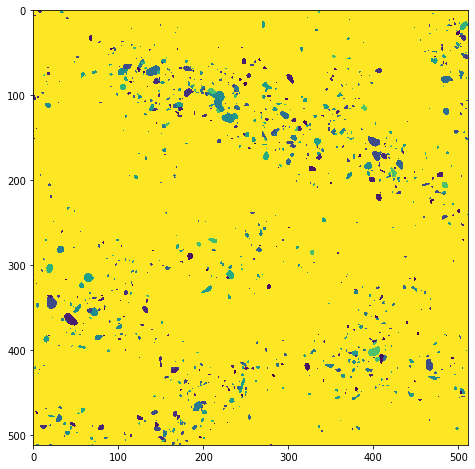

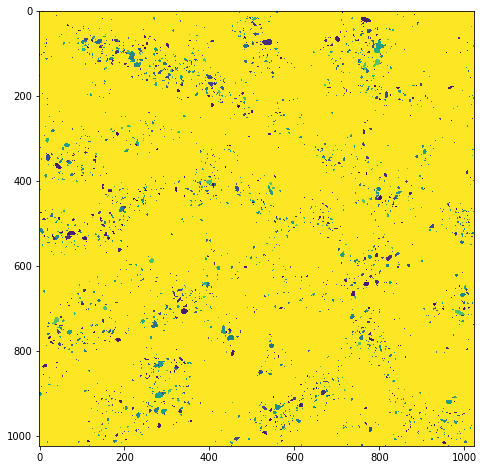

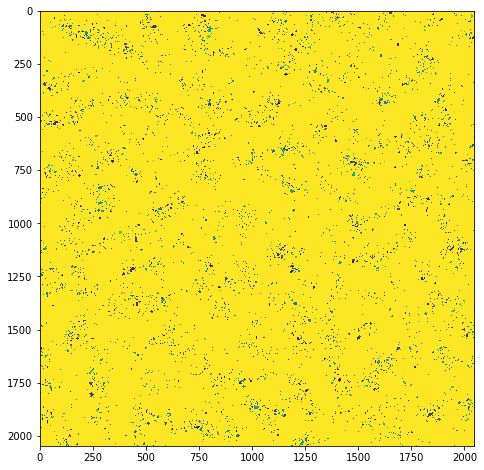

In [9]:
print(np.count_nonzero(world_map))
unique, counts = np.unique(world_map, return_counts=True)
count_dict = dict(zip(unique, counts))
print(count_dict)
print(height * width - counts[-1])

for k, v in oretypes.items():
    print(k, v)
    total = 0
    for t in v:
        total += count_dict[t]
    print('{}: {}'.format(k, total))
        

fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(world_map[:512, :512])
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(world_map[:1024, :1024])
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(world_map)


In [ ]:
def filaments(generate=False):
    #octaves = (7, 13, 19, 27, 35, 51, 91)
    octaves = (5, 9, 17, 29, 39, 51, 91)
    gen_height = 2048
    gen_width = 2048

    if generate:
        noise = get_sub_noise(gen_height, gen_width, octaves)
        save_noise('seven_octaves_1024.npz', noise)
    else:
        noise = load_noise('seven_octaves_1024.npz')
    
    normnoise = {k:np.interp(v, (v.min(), v.max()), (0, 1)) for k,v in noise.items()}
    fig, ax = plt.subplots(5, 2, figsize=(12,24))
    for ki, k in enumerate(normnoise.keys()):
        r = ki // 2
        c = ki % 2
        ax[r, c].imshow(normnoise[k])
    ks = list(normnoise.keys())
    filament = np.sqrt(normnoise[ks[-1]]).clip(0.5, 1.0)
#     filament_sum = (normnoise[ks[-1]] + normnoise[ks[-2]]) / 2
#     filament_clip = np.sqrt(filament_sum.clip(0.5, 1.0))
#     filament = np.interp(filament_sum, (filament_sum.min(), filament_sum.max()), (0, 1))
#     anti_filament = 1 - filament_sum.clip(0.0, 0.7)
    ax[3, 1].imshow(filament)
#     ax[4, 0].imshow(anti_filament)
    
    
            
filaments(False)

119


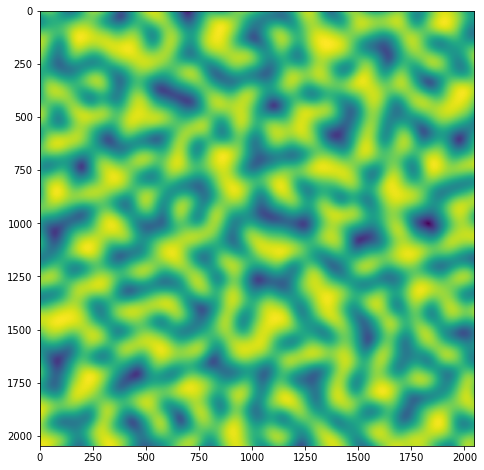

In [17]:
test_noise = get_sub_noise(2048, 2048, (119,))
fnoise = test_noise[119]
fnoise = np.sqrt(np.interp(fnoise, (fnoise.min(), fnoise.max()), (0, 1)))
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(fnoise)

In [19]:
ore_noise = get_ore_noise(height, width, octaves, world_noise, fnoise, ore_defns, 0.2, 0.6)
world_map = get_world_map(ore_noise, ore_defns)

64 64
stacking
consolidating
4194304
[  1   4   8  12  16  20  21  22  24  26  28  30  32  34  35  36  48  50
  52  54  56  58  59  60  72  76  80  84  88  92  93  94  96  98 102 104
 106 108 109 110 120 121 122 123 124 125 132 134 136 138 140 142 143 144
 156 158 164 165 168 172 176 180 184 188 255] [   1702    1715    1712    2329    2271    2274    3545    3474    1743
    1720    1767    2287    2307    2295    3465    3459    1740    1698
    1721    2267    2267    2284    3494    3447    1446    1412    1455
    2009    2039    2074    2943    2772    2031    2027    1942    1970
    2082    1961    2363    2354    1306    1303    1842    1865    2658
    2546    3424    3404    3483    3407    3429    3330    5720    5634
     890    1459     590    1768    1303    1289    1841    1817    2628
    2515 4044990]
149314


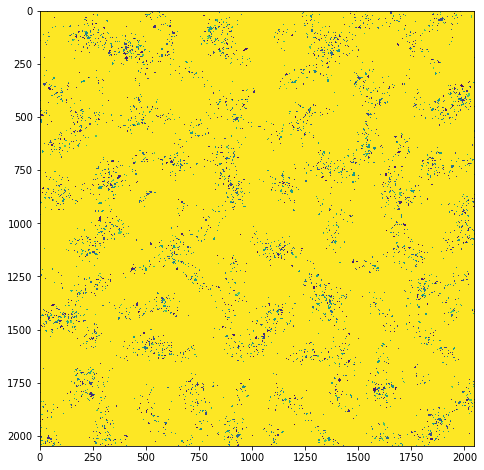

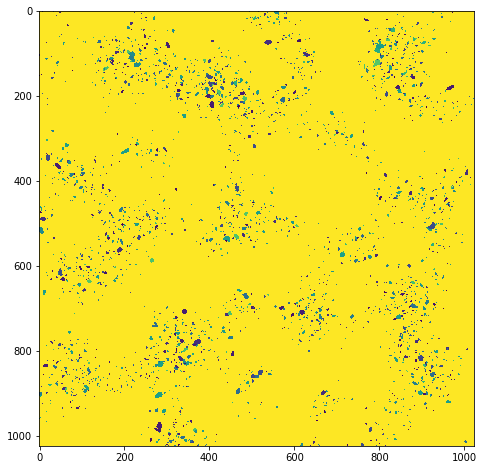

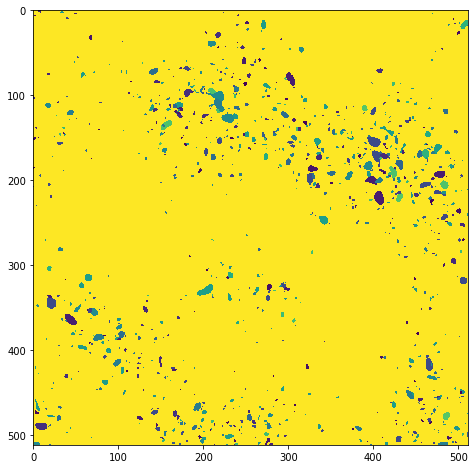

In [20]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(world_map)
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(world_map[:1024, :1024])
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(world_map[:512, :512])